In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=123456789)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=10000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=1)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=20)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=123456789, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=1, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=10000)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='additive'
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [6]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)

  1%|          | 1/100 [01:00<1:39:42, 60.43s/it]

{'regret_max': 0.7128500938415527, 'regret_mean': 0.013647720217704773, 'regret_mults': tensor([[5.5947]], device='cuda:0'), 'payment': 0.4599155783653259}


  2%|▏         | 2/100 [02:00<1:38:40, 60.41s/it]

{'regret_max': 0.05760931968688965, 'regret_mean': 0.004995813127607107, 'regret_mults': tensor([[6.1247]], device='cuda:0'), 'payment': 0.5506418943405151}


  3%|▎         | 3/100 [03:01<1:37:48, 60.50s/it]

{'regret_max': 0.06193101406097412, 'regret_mean': 0.003718577791005373, 'regret_mults': tensor([[7.7347]], device='cuda:0'), 'payment': 0.5540871620178223}


  4%|▍         | 4/100 [04:02<1:36:49, 60.52s/it]

{'regret_max': 0.038950204849243164, 'regret_mean': 0.0028591693844646215, 'regret_mults': tensor([[10.4252]], device='cuda:0'), 'payment': 0.5529738068580627}


  5%|▌         | 5/100 [05:02<1:35:50, 60.53s/it]

{'regret_max': 0.05065631866455078, 'regret_mean': 0.0024946117773652077, 'regret_mults': tensor([[11.8599]], device='cuda:0'), 'payment': 0.5497082471847534}


  6%|▌         | 6/100 [06:03<1:34:55, 60.59s/it]

{'regret_max': 0.04201054573059082, 'regret_mean': 0.002222798764705658, 'regret_mults': tensor([[14.1243]], device='cuda:0'), 'payment': 0.546592116355896}


  7%|▋         | 7/100 [07:03<1:33:52, 60.56s/it]

{'regret_max': 0.04344654083251953, 'regret_mean': 0.0020514640491455793, 'regret_mults': tensor([[14.7238]], device='cuda:0'), 'payment': 0.5438109636306763}


  8%|▊         | 8/100 [08:04<1:32:49, 60.54s/it]

{'regret_max': 0.034753620624542236, 'regret_mean': 0.0017570388736203313, 'regret_mults': tensor([[18.9892]], device='cuda:0'), 'payment': 0.5434609055519104}


  9%|▉         | 9/100 [09:04<1:31:50, 60.55s/it]

{'regret_max': 0.028421342372894287, 'regret_mean': 0.0014522153651341796, 'regret_mults': tensor([[19.5904]], device='cuda:0'), 'payment': 0.5428190231323242}


 10%|█         | 10/100 [10:05<1:30:53, 60.60s/it]

{'regret_max': 0.02365243434906006, 'regret_mean': 0.0013572834432125092, 'regret_mults': tensor([[20.4007]], device='cuda:0'), 'payment': 0.5431472063064575}


 11%|█         | 11/100 [11:05<1:29:46, 60.52s/it]

{'regret_max': 0.028180837631225586, 'regret_mean': 0.0012247007107362151, 'regret_mults': tensor([[21.9478]], device='cuda:0'), 'payment': 0.541620135307312}


 12%|█▏        | 12/100 [12:05<1:28:31, 60.35s/it]

{'regret_max': 0.01731717586517334, 'regret_mean': 0.0010609899181872606, 'regret_mults': tensor([[22.9243]], device='cuda:0'), 'payment': 0.544410228729248}


 13%|█▎        | 13/100 [13:05<1:27:20, 60.23s/it]

{'regret_max': 0.018813371658325195, 'regret_mean': 0.0010160775855183601, 'regret_mults': tensor([[27.0588]], device='cuda:0'), 'payment': 0.5436726808547974}


 14%|█▍        | 14/100 [14:05<1:26:10, 60.13s/it]

{'regret_max': 0.020750045776367188, 'regret_mean': 0.000900399754755199, 'regret_mults': tensor([[27.7079]], device='cuda:0'), 'payment': 0.5443755388259888}


 15%|█▌        | 15/100 [15:05<1:25:02, 60.04s/it]

{'regret_max': 0.01740550994873047, 'regret_mean': 0.0008941419655457139, 'regret_mults': tensor([[29.8254]], device='cuda:0'), 'payment': 0.5419021248817444}


 16%|█▌        | 16/100 [16:05<1:23:57, 59.97s/it]

{'regret_max': 0.011521637439727783, 'regret_mean': 0.0006481012678705156, 'regret_mults': tensor([[30.9690]], device='cuda:0'), 'payment': 0.544522762298584}


 17%|█▋        | 17/100 [17:04<1:22:45, 59.83s/it]

{'regret_max': 0.011121094226837158, 'regret_mean': 0.000602001091465354, 'regret_mults': tensor([[34.5079]], device='cuda:0'), 'payment': 0.5430692434310913}


 18%|█▊        | 18/100 [18:04<1:21:32, 59.67s/it]

{'regret_max': 0.01113218069076538, 'regret_mean': 0.0005347108235582709, 'regret_mults': tensor([[35.7606]], device='cuda:0'), 'payment': 0.5411642789840698}


 19%|█▉        | 19/100 [19:03<1:20:31, 59.65s/it]

{'regret_max': 0.011820614337921143, 'regret_mean': 0.000569286523386836, 'regret_mults': tensor([[36.8233]], device='cuda:0'), 'payment': 0.5416895747184753}


 20%|██        | 20/100 [20:03<1:19:37, 59.72s/it]

{'regret_max': 0.010326504707336426, 'regret_mean': 0.0004713268135674298, 'regret_mults': tensor([[37.3632]], device='cuda:0'), 'payment': 0.5426688194274902}


 21%|██        | 21/100 [21:03<1:18:38, 59.72s/it]

{'regret_max': 0.010091662406921387, 'regret_mean': 0.0004307847120799124, 'regret_mults': tensor([[38.0139]], device='cuda:0'), 'payment': 0.5433671474456787}


 22%|██▏       | 22/100 [22:03<1:17:43, 59.79s/it]

{'regret_max': 0.011500418186187744, 'regret_mean': 0.00044768222142010927, 'regret_mults': tensor([[40.6544]], device='cuda:0'), 'payment': 0.541728138923645}


 23%|██▎       | 23/100 [23:03<1:16:40, 59.75s/it]

{'regret_max': 0.01048964262008667, 'regret_mean': 0.00041725856135599315, 'regret_mults': tensor([[41.3361]], device='cuda:0'), 'payment': 0.5440754294395447}


 24%|██▍       | 24/100 [24:02<1:15:41, 59.76s/it]

{'regret_max': 0.0107651948928833, 'regret_mean': 0.00040792854269966483, 'regret_mults': tensor([[42.3530]], device='cuda:0'), 'payment': 0.5447150468826294}


 25%|██▌       | 25/100 [25:02<1:14:30, 59.61s/it]

{'regret_max': 0.009844064712524414, 'regret_mean': 0.00041244691237807274, 'regret_mults': tensor([[43.3362]], device='cuda:0'), 'payment': 0.5441490411758423}


 26%|██▌       | 26/100 [26:01<1:13:36, 59.68s/it]

{'regret_max': 0.011278092861175537, 'regret_mean': 0.00031540062627755105, 'regret_mults': tensor([[44.1008]], device='cuda:0'), 'payment': 0.5468612909317017}


 27%|██▋       | 27/100 [27:01<1:12:34, 59.65s/it]

{'regret_max': 0.011118769645690918, 'regret_mean': 0.0004238881228957325, 'regret_mults': tensor([[45.2114]], device='cuda:0'), 'payment': 0.5453776121139526}


 28%|██▊       | 28/100 [28:01<1:11:40, 59.74s/it]

{'regret_max': 0.011375129222869873, 'regret_mean': 0.00033888762118294835, 'regret_mults': tensor([[46.2094]], device='cuda:0'), 'payment': 0.5467432737350464}


 29%|██▉       | 29/100 [29:00<1:10:20, 59.45s/it]

{'regret_max': 0.011384010314941406, 'regret_mean': 0.0003601759672164917, 'regret_mults': tensor([[48.5449]], device='cuda:0'), 'payment': 0.5465087294578552}


 30%|███       | 30/100 [29:59<1:09:11, 59.31s/it]

{'regret_max': 0.014927327632904053, 'regret_mean': 0.00035170791670680046, 'regret_mults': tensor([[50.8693]], device='cuda:0'), 'payment': 0.5463923811912537}


 31%|███       | 31/100 [30:55<1:07:11, 58.43s/it]

{'regret_max': 0.013949811458587646, 'regret_mean': 0.00032967134029604495, 'regret_mults': tensor([[53.4515]], device='cuda:0'), 'payment': 0.5464004278182983}


 32%|███▏      | 32/100 [31:50<1:05:10, 57.51s/it]

{'regret_max': 0.01170879602432251, 'regret_mean': 0.0002922684361692518, 'regret_mults': tensor([[54.5981]], device='cuda:0'), 'payment': 0.5467706918716431}


 33%|███▎      | 33/100 [32:46<1:03:27, 56.83s/it]

{'regret_max': 0.010002315044403076, 'regret_mean': 0.0002998185809701681, 'regret_mults': tensor([[56.5933]], device='cuda:0'), 'payment': 0.5475853085517883}


 34%|███▍      | 34/100 [33:41<1:02:01, 56.38s/it]

{'regret_max': 0.012604594230651855, 'regret_mean': 0.000324252643622458, 'regret_mults': tensor([[57.9664]], device='cuda:0'), 'payment': 0.5452877283096313}


 35%|███▌      | 35/100 [34:37<1:00:48, 56.14s/it]

{'regret_max': 0.010452032089233398, 'regret_mean': 0.00025470409309491515, 'regret_mults': tensor([[58.7451]], device='cuda:0'), 'payment': 0.5473204851150513}


 36%|███▌      | 36/100 [35:32<59:36, 55.88s/it]  

{'regret_max': 0.011000394821166992, 'regret_mean': 0.0002782681258395314, 'regret_mults': tensor([[62.1721]], device='cuda:0'), 'payment': 0.5472819805145264}


 37%|███▋      | 37/100 [36:27<58:27, 55.68s/it]

{'regret_max': 0.01074516773223877, 'regret_mean': 0.0002778884954750538, 'regret_mults': tensor([[63.1771]], device='cuda:0'), 'payment': 0.5456759929656982}


 38%|███▊      | 38/100 [37:22<57:21, 55.51s/it]

{'regret_max': 0.011265754699707031, 'regret_mean': 0.0003030558582395315, 'regret_mults': tensor([[63.9708]], device='cuda:0'), 'payment': 0.5454151034355164}


 39%|███▉      | 39/100 [38:17<56:20, 55.42s/it]

{'regret_max': 0.01129460334777832, 'regret_mean': 0.0002546183532103896, 'regret_mults': tensor([[66.8028]], device='cuda:0'), 'payment': 0.5460131764411926}


 40%|████      | 40/100 [39:13<55:22, 55.37s/it]

{'regret_max': 0.010582804679870605, 'regret_mean': 0.0002457244845572859, 'regret_mults': tensor([[69.0249]], device='cuda:0'), 'payment': 0.5454258918762207}


 41%|████      | 41/100 [40:08<54:23, 55.31s/it]

{'regret_max': 0.011094748973846436, 'regret_mean': 0.0002268732205266133, 'regret_mults': tensor([[69.5964]], device='cuda:0'), 'payment': 0.5451489090919495}


 42%|████▏     | 42/100 [41:03<53:26, 55.29s/it]

{'regret_max': 0.009750008583068848, 'regret_mean': 0.00024133763508871198, 'regret_mults': tensor([[71.3667]], device='cuda:0'), 'payment': 0.5453301072120667}


 43%|████▎     | 43/100 [41:58<52:29, 55.26s/it]

{'regret_max': 0.010984241962432861, 'regret_mean': 0.0002387635177001357, 'regret_mults': tensor([[74.4309]], device='cuda:0'), 'payment': 0.5455560088157654}


 44%|████▍     | 44/100 [42:54<51:34, 55.26s/it]

{'regret_max': 0.011586427688598633, 'regret_mean': 0.00026775075821205974, 'regret_mults': tensor([[75.3148]], device='cuda:0'), 'payment': 0.5441840887069702}


 45%|████▌     | 45/100 [43:49<50:37, 55.23s/it]

{'regret_max': 0.007966160774230957, 'regret_mean': 0.000221010617678985, 'regret_mults': tensor([[75.9973]], device='cuda:0'), 'payment': 0.5438975691795349}


 46%|████▌     | 46/100 [44:44<49:40, 55.20s/it]

{'regret_max': 0.010971665382385254, 'regret_mean': 0.0002518473193049431, 'regret_mults': tensor([[76.9623]], device='cuda:0'), 'payment': 0.5449262261390686}


 47%|████▋     | 47/100 [45:39<48:45, 55.19s/it]

{'regret_max': 0.009057581424713135, 'regret_mean': 0.00018280293443240225, 'regret_mults': tensor([[78.1172]], device='cuda:0'), 'payment': 0.5454658269882202}


 48%|████▊     | 48/100 [46:34<47:50, 55.21s/it]

{'regret_max': 0.010519683361053467, 'regret_mean': 0.00019810620869975537, 'regret_mults': tensor([[78.5477]], device='cuda:0'), 'payment': 0.5461122989654541}


 49%|████▉     | 49/100 [47:29<46:56, 55.22s/it]

{'regret_max': 0.008195936679840088, 'regret_mean': 0.0002078946417896077, 'regret_mults': tensor([[79.4638]], device='cuda:0'), 'payment': 0.5445285439491272}


 50%|█████     | 50/100 [48:25<46:00, 55.20s/it]

{'regret_max': 0.010032415390014648, 'regret_mean': 0.00020272233814466745, 'regret_mults': tensor([[84.3013]], device='cuda:0'), 'payment': 0.5458601713180542}


 51%|█████     | 51/100 [49:20<45:03, 55.18s/it]

{'regret_max': 0.011645078659057617, 'regret_mean': 0.0002378406934440136, 'regret_mults': tensor([[85.3772]], device='cuda:0'), 'payment': 0.5432115793228149}


 52%|█████▏    | 52/100 [50:15<44:10, 55.21s/it]

{'regret_max': 0.007769107818603516, 'regret_mean': 0.00018950749654322863, 'regret_mults': tensor([[86.3190]], device='cuda:0'), 'payment': 0.5442999601364136}


 53%|█████▎    | 53/100 [51:10<43:15, 55.22s/it]

{'regret_max': 0.010577499866485596, 'regret_mean': 0.0002088096662191674, 'regret_mults': tensor([[87.2876]], device='cuda:0'), 'payment': 0.5437558889389038}


 54%|█████▍    | 54/100 [52:06<42:21, 55.24s/it]

{'regret_max': 0.008531332015991211, 'regret_mean': 0.00018350132449995726, 'regret_mults': tensor([[90.5885]], device='cuda:0'), 'payment': 0.5439876317977905}


 55%|█████▌    | 55/100 [53:01<41:27, 55.27s/it]

{'regret_max': 0.008044004440307617, 'regret_mean': 0.00017038240912370384, 'regret_mults': tensor([[91.4776]], device='cuda:0'), 'payment': 0.5445038676261902}


 56%|█████▌    | 56/100 [53:56<40:31, 55.26s/it]

{'regret_max': 0.007576704025268555, 'regret_mean': 0.00020612897060345858, 'regret_mults': tensor([[91.9726]], device='cuda:0'), 'payment': 0.5432679653167725}


 57%|█████▋    | 57/100 [54:51<39:36, 55.27s/it]

{'regret_max': 0.007545650005340576, 'regret_mean': 0.00016850451356731355, 'regret_mults': tensor([[93.2292]], device='cuda:0'), 'payment': 0.5445104837417603}


 58%|█████▊    | 58/100 [55:47<38:41, 55.28s/it]

{'regret_max': 0.020759999752044678, 'regret_mean': 0.00028700949042104185, 'regret_mults': tensor([[96.7173]], device='cuda:0'), 'payment': 0.5427278280258179}


 59%|█████▉    | 59/100 [56:42<37:46, 55.27s/it]

{'regret_max': 0.007795751094818115, 'regret_mean': 0.00016519342898391187, 'regret_mults': tensor([[97.3797]], device='cuda:0'), 'payment': 0.5438775420188904}


 60%|██████    | 60/100 [57:37<36:53, 55.33s/it]

{'regret_max': 0.008735954761505127, 'regret_mean': 0.00017664695042185485, 'regret_mults': tensor([[97.9583]], device='cuda:0'), 'payment': 0.5438765287399292}


 61%|██████    | 61/100 [58:33<36:01, 55.42s/it]

{'regret_max': 0.00835353136062622, 'regret_mean': 0.00014327041571959853, 'regret_mults': tensor([[99.6082]], device='cuda:0'), 'payment': 0.5444018840789795}


 62%|██████▏   | 62/100 [59:28<35:03, 55.35s/it]

{'regret_max': 0.007580459117889404, 'regret_mean': 0.00017513730563223362, 'regret_mults': tensor([[100.9003]], device='cuda:0'), 'payment': 0.5446529388427734}


 63%|██████▎   | 63/100 [1:00:25<34:21, 55.72s/it]

{'regret_max': 0.007575631141662598, 'regret_mean': 0.00014745561929885298, 'regret_mults': tensor([[101.6582]], device='cuda:0'), 'payment': 0.5440018177032471}


 64%|██████▍   | 64/100 [1:01:22<33:40, 56.11s/it]

{'regret_max': 0.007620632648468018, 'regret_mean': 0.00014914694475010037, 'regret_mults': tensor([[104.0254]], device='cuda:0'), 'payment': 0.5441044569015503}


 65%|██████▌   | 65/100 [1:02:19<32:49, 56.28s/it]

{'regret_max': 0.012903690338134766, 'regret_mean': 0.00020650791702792048, 'regret_mults': tensor([[108.4927]], device='cuda:0'), 'payment': 0.5438339114189148}


 66%|██████▌   | 66/100 [1:03:16<32:00, 56.48s/it]

{'regret_max': 0.007097333669662476, 'regret_mean': 0.0001495014876127243, 'regret_mults': tensor([[108.9575]], device='cuda:0'), 'payment': 0.5417429208755493}


 67%|██████▋   | 67/100 [1:04:13<31:16, 56.87s/it]

{'regret_max': 0.008773386478424072, 'regret_mean': 0.00018315012857783586, 'regret_mults': tensor([[110.0529]], device='cuda:0'), 'payment': 0.5430014133453369}


 68%|██████▊   | 68/100 [1:05:10<30:14, 56.70s/it]

{'regret_max': 0.007211863994598389, 'regret_mean': 0.00012978145969100296, 'regret_mults': tensor([[111.5693]], device='cuda:0'), 'payment': 0.5426269769668579}


 69%|██████▉   | 69/100 [1:06:05<29:04, 56.27s/it]

{'regret_max': 0.008149862289428711, 'regret_mean': 0.0001785824279068038, 'regret_mults': tensor([[113.0605]], device='cuda:0'), 'payment': 0.5417743921279907}


 70%|███████   | 70/100 [1:07:00<28:01, 56.05s/it]

{'regret_max': 0.0067555904388427734, 'regret_mean': 0.00011190240911673754, 'regret_mults': tensor([[114.3671]], device='cuda:0'), 'payment': 0.5443593859672546}


 71%|███████   | 71/100 [1:07:56<26:58, 55.81s/it]

{'regret_max': 0.008122503757476807, 'regret_mean': 0.00014135024684946984, 'regret_mults': tensor([[116.7671]], device='cuda:0'), 'payment': 0.5436667799949646}


 72%|███████▏  | 72/100 [1:08:51<25:57, 55.62s/it]

{'regret_max': 0.15052053332328796, 'regret_mean': 0.000804106006398797, 'regret_mults': tensor([[127.9994]], device='cuda:0'), 'payment': 0.5414669513702393}


 73%|███████▎  | 73/100 [1:09:47<25:08, 55.87s/it]

{'regret_max': 0.28185537457466125, 'regret_mean': 0.006111775524914265, 'regret_mults': tensor([[132.6770]], device='cuda:0'), 'payment': 0.4239824414253235}


 74%|███████▍  | 74/100 [1:10:46<24:34, 56.71s/it]

{'regret_max': 0.0044297873973846436, 'regret_mean': 0.00023321282060351223, 'regret_mults': tensor([[135.3427]], device='cuda:0'), 'payment': 0.46357113122940063}


 75%|███████▌  | 75/100 [1:11:45<23:53, 57.34s/it]

{'regret_max': 0.004561275243759155, 'regret_mean': 0.00019185480778105557, 'regret_mults': tensor([[140.0908]], device='cuda:0'), 'payment': 0.501512885093689}


 76%|███████▌  | 76/100 [1:12:43<23:05, 57.72s/it]

{'regret_max': 0.004989027976989746, 'regret_mean': 0.00013326224870979786, 'regret_mults': tensor([[140.8983]], device='cuda:0'), 'payment': 0.5231470465660095}


 77%|███████▋  | 77/100 [1:13:42<22:13, 57.98s/it]

{'regret_max': 0.005065560340881348, 'regret_mean': 8.195490227080882e-05, 'regret_mults': tensor([[141.8130]], device='cuda:0'), 'payment': 0.5335069894790649}


 78%|███████▊  | 78/100 [1:14:41<21:21, 58.24s/it]

{'regret_max': 0.005366981029510498, 'regret_mean': 7.352590910159051e-05, 'regret_mults': tensor([[142.4260]], device='cuda:0'), 'payment': 0.5381775498390198}


 79%|███████▉  | 79/100 [1:15:39<20:22, 58.20s/it]

{'regret_max': 0.0049440860748291016, 'regret_mean': 6.782098353141919e-05, 'regret_mults': tensor([[144.0041]], device='cuda:0'), 'payment': 0.5404605865478516}


 80%|████████  | 80/100 [1:16:37<19:24, 58.22s/it]

{'regret_max': 0.004718661308288574, 'regret_mean': 6.393957301042974e-05, 'regret_mults': tensor([[144.4837]], device='cuda:0'), 'payment': 0.5412827730178833}


 81%|████████  | 81/100 [1:17:36<18:27, 58.28s/it]

{'regret_max': 0.004209578037261963, 'regret_mean': 8.071408956311643e-05, 'regret_mults': tensor([[144.9985]], device='cuda:0'), 'payment': 0.5417370796203613}


 82%|████████▏ | 82/100 [1:18:34<17:30, 58.34s/it]

{'regret_max': 0.004173994064331055, 'regret_mean': 7.05913407728076e-05, 'regret_mults': tensor([[145.4526]], device='cuda:0'), 'payment': 0.5429597496986389}


 83%|████████▎ | 83/100 [1:19:32<16:30, 58.27s/it]

{'regret_max': 0.00420224666595459, 'regret_mean': 5.471567055792548e-05, 'regret_mults': tensor([[147.2125]], device='cuda:0'), 'payment': 0.5435721278190613}


 84%|████████▍ | 84/100 [1:20:30<15:32, 58.28s/it]

{'regret_max': 0.005929768085479736, 'regret_mean': 9.442349255550653e-05, 'regret_mults': tensor([[147.7737]], device='cuda:0'), 'payment': 0.5433006286621094}


 85%|████████▌ | 85/100 [1:21:29<14:35, 58.38s/it]

{'regret_max': 0.004515171051025391, 'regret_mean': 6.914872938068584e-05, 'regret_mults': tensor([[148.2097]], device='cuda:0'), 'payment': 0.5438259243965149}


 86%|████████▌ | 86/100 [1:22:28<13:38, 58.44s/it]

{'regret_max': 0.006001889705657959, 'regret_mean': 8.834688196657225e-05, 'regret_mults': tensor([[149.3593]], device='cuda:0'), 'payment': 0.5437127351760864}


 87%|████████▋ | 87/100 [1:23:26<12:39, 58.41s/it]

{'regret_max': 0.00476306676864624, 'regret_mean': 5.646018325933255e-05, 'regret_mults': tensor([[149.7836]], device='cuda:0'), 'payment': 0.5436602234840393}


 88%|████████▊ | 88/100 [1:24:25<11:42, 58.57s/it]

{'regret_max': 0.005868792533874512, 'regret_mean': 9.072378452401608e-05, 'regret_mults': tensor([[150.2751]], device='cuda:0'), 'payment': 0.5442554950714111}


 89%|████████▉ | 89/100 [1:25:23<10:43, 58.49s/it]

{'regret_max': 0.004821479320526123, 'regret_mean': 8.04395240265876e-05, 'regret_mults': tensor([[151.3277]], device='cuda:0'), 'payment': 0.5432868003845215}


 90%|█████████ | 90/100 [1:26:22<09:44, 58.43s/it]

{'regret_max': 0.004638254642486572, 'regret_mean': 8.292287384392694e-05, 'regret_mults': tensor([[154.5705]], device='cuda:0'), 'payment': 0.5429155826568604}


 91%|█████████ | 91/100 [1:27:20<08:44, 58.30s/it]

{'regret_max': 0.003915369510650635, 'regret_mean': 5.363780655898154e-05, 'regret_mults': tensor([[154.9971]], device='cuda:0'), 'payment': 0.5432610511779785}


 92%|█████████▏| 92/100 [1:28:18<07:47, 58.39s/it]

{'regret_max': 0.00893712043762207, 'regret_mean': 0.0001413465361110866, 'regret_mults': tensor([[160.4000]], device='cuda:0'), 'payment': 0.5410798788070679}


 93%|█████████▎| 93/100 [1:29:17<06:49, 58.50s/it]

{'regret_max': 0.006358623504638672, 'regret_mean': 8.413442992605269e-05, 'regret_mults': tensor([[168.9700]], device='cuda:0'), 'payment': 0.5426528453826904}


 94%|█████████▍| 94/100 [1:30:16<05:51, 58.66s/it]

{'regret_max': 0.005369603633880615, 'regret_mean': 8.488378807669505e-05, 'regret_mults': tensor([[169.5703]], device='cuda:0'), 'payment': 0.5404461026191711}


 95%|█████████▌| 95/100 [1:31:15<04:53, 58.69s/it]

{'regret_max': 0.00496518611907959, 'regret_mean': 8.068475290201604e-05, 'regret_mults': tensor([[170.1392]], device='cuda:0'), 'payment': 0.5409595370292664}


 96%|█████████▌| 96/100 [1:32:13<03:54, 58.73s/it]

{'regret_max': 0.0033922195434570312, 'regret_mean': 7.04557096469216e-05, 'regret_mults': tensor([[171.1257]], device='cuda:0'), 'payment': 0.5413433313369751}


 97%|█████████▋| 97/100 [1:33:12<02:56, 58.78s/it]

{'regret_max': 0.003306269645690918, 'regret_mean': 6.08280097367242e-05, 'regret_mults': tensor([[172.9159]], device='cuda:0'), 'payment': 0.5416477918624878}


 98%|█████████▊| 98/100 [1:34:11<01:57, 58.72s/it]

{'regret_max': 0.0046048760414123535, 'regret_mean': 8.151217480190098e-05, 'regret_mults': tensor([[174.0580]], device='cuda:0'), 'payment': 0.5431185960769653}


 99%|█████████▉| 99/100 [1:35:10<00:58, 58.83s/it]

{'regret_max': 0.00460439920425415, 'regret_mean': 0.00010145120904780924, 'regret_mults': tensor([[174.6010]], device='cuda:0'), 'payment': 0.5396455526351929}


100%|██████████| 100/100 [1:36:09<00:00, 57.70s/it]

{'regret_max': 0.004158198833465576, 'regret_mean': 4.461109347175807e-05, 'regret_mults': tensor([[180.8074]], device='cuda:0'), 'payment': 0.5424116849899292}
CPU times: user 1h 35min 50s, sys: 12.2 s, total: 1h 36min 2s
Wall time: 1h 36min 9s


In [7]:
dir_name = 'additive_1x2_0_1_experiment_data/'
test_data = torch.load(dir_name + 'test_data')

In [8]:
%%time

# test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)

test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [00:34, 34.08s/it]

CPU times: user 34 s, sys: 83 ms, total: 34.1 s
Wall time: 34.1 s


{'payment_mean': 0.5459543466567993,
 'regret_mean': 0.0004619850660674274,
 'regret_max': 0.0032276511192321777}

In [9]:
def additive_1x2_0_1_optimal_mechanism(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        if bids[i, :, 0] > (2 / 3) and bids[i, :, 1] < (2 - math.sqrt(2)) / 3:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = 2 / 3
        elif bids[i, :, 1] > (2 / 3) and bids[i, :, 0] < (2 - math.sqrt(2)) / 3:
            allocs[i, 0, :] = torch.tensor([0, 1])
            payments[i, :] = 2 / 3
        elif (2 - math.sqrt(2)) / 3 - bids[i, :, 0] < bids[i, 0, 1] - 2 / 3:
            allocs[i, 0, :] = torch.tensor([1, 1])
            payments[i, :] = 4 / 3 - math.sqrt(2) / 3
    return allocs, payments

opt_alloc, opt_payments = additive_1x2_0_1_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.5570)

In [18]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
model.sinkhorn_rounds = 100
model.sinkhorn_epsilon = 4e-2

random_starts = [test_data]
for i in range(10):
    random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [26:50, 1610.78s/it]

CPU times: user 13min 42s, sys: 610 ms, total: 13min 43s
Wall time: 26min 50s


{'payment_mean': 0.5565372705459595,
 'regret_mean': 0.0014233565889298916,
 'regret_max': 0.005724132061004639}

In [11]:
model.save(dir_name)

In [12]:
cpu_model = DoubleNet.load(dir_name).to(device='cpu')

In [13]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

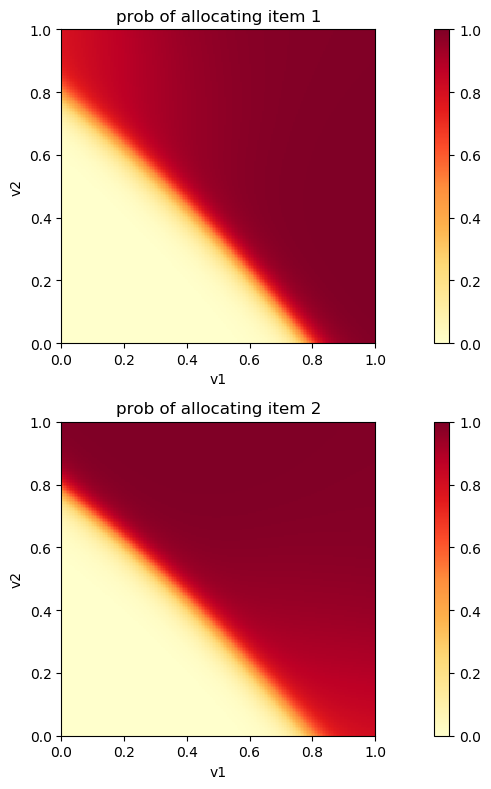

In [14]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
cpu_model.sinkhorn_rounds = 100
cpu_model.sinkhorn_epsilon = 4e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

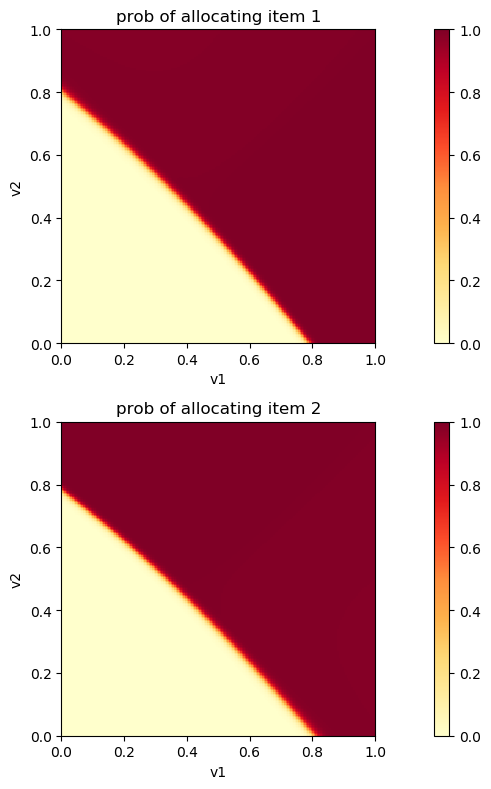

In [15]:
cpu_model.sinkhorn_rounds = 100
cpu_model.sinkhorn_epsilon = 1e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))

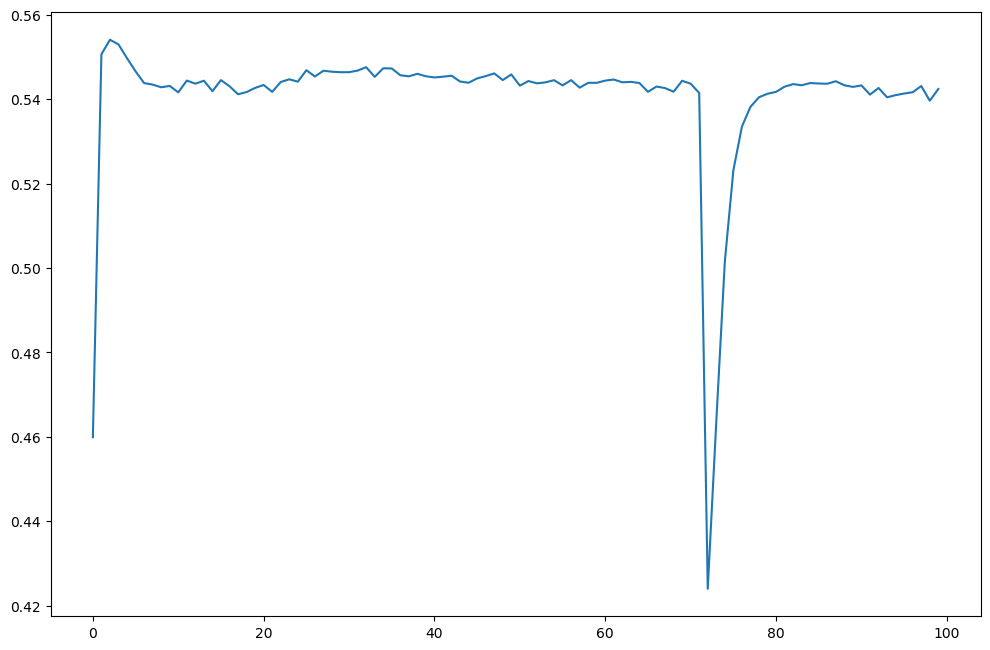

In [16]:
import matplotlib.pyplot as plt
plt.plot(mean_pay)

In [17]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)